# Evaluate performance

In [1]:
import os
import glob
import xarray as xr
import pandas as pd
import numpy as np

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.inspection import permutation_importance

import shap
shap.initjs()

from scipy.stats import pearsonr, randint, uniform

import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib.lines import Line2D

import string
letters = list(string.ascii_lowercase)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [3]:
%load_ext autoreload
%autoreload 2

### Set global variables

In [4]:
RESULTS_PATH = "/g/data/w42/dr6273/work/projects/Aus_energy/model_results/"

In [5]:
MARKET = "NEM" # "NEM" or "EU"

In [6]:
REMOVE_MONTH = 0 # integer: [1, 12]

In [7]:
# TIME_COLUMNS = ["is_weekend"]

In [8]:
FIRST_TRAIN_YEAR = 2010
LAST_TRAIN_YEAR = 2016

In [9]:
FIRST_TEST_YEAR = 2017
LAST_TEST_YEAR = 2019

In [10]:
regions = ["NEM", "QLD", "NSW", "VIC", "SA", "TAS"]

# Feature selection

In [11]:
def plot_feature_selection(ax, results, label, pars_results=None, col1="tab:blue", col2="tab:red"):
    """
    Plot average score +/- standard error
    
    ax: axes
    result: pandas dataframe with avg_score and std_dev columns
    label: str, label for legend
    pars_results: pandas dataframe with avg_score and std_dev columns, to mark another point e.g. most parsimonious model
    """
    avg_score = results["avg_score"].values / 1000
    se = results["std_err"].values / 1000
    score_max = np.where(results["selected_features"] == True)[0][0]
    
    p = ax.plot(avg_score, marker="", c=col1, zorder=1, label=label)
    ax.fill_between(range(len(se)), avg_score + se, avg_score - se, alpha=0.3, color=col1, zorder=1)
    ax.scatter(range(len(avg_score))[score_max], avg_score[score_max], zorder=2, c=col2, marker="^", ec="k", s=70)
    
    if pars_results is not None:
        pars_score = np.where(pars_results["selected_features"] == True)[0][0]
        ax.scatter(range(len(avg_score))[pars_score], avg_score[pars_score], zorder=2, c=col2, marker="o", ec="k", s=70)
    
    ax.axes.grid(zorder=0)
    ax.set_axisbelow(True)
    ax.set_xticks(range(len(avg_score))[::3])
    ax.set_xticklabels(range(1, len(avg_score) + 1)[::3])
    ax.set_xlabel("Number of features")
    ax.set_ylabel(r"-MAE [GWh d$^{-1}$]")
    
    return p

Read data

In [12]:
# Population density mask, all data
features_dict_best = fn.read_results(
    "feature_selection", MARKET, regions, "pop_dens_mask",
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    False, False, REMOVE_MONTH, "best", RESULTS_PATH
)
features_dict_pars = fn.read_results(
    "feature_selection", MARKET, regions, "pop_dens_mask",
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    False, False, REMOVE_MONTH, "parsimonious", RESULTS_PATH
)

In [13]:
features_dict_best["NSW"].head()

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,selected_features
1,"(0,)",[-12178.98890078 -12448.85078919 -11918.857417...,-11740.974006,['is_weekend'],912.194877,944.933214,385.767369,False
2,"(0, 10)",[-8028.01335979 -8092.12961678 -7469.86650728 ...,-7759.019563,"['is_weekend', 't2m']",541.141223,560.562582,228.848716,False
3,"(0, 10, 11)",[-5519.35380021 -6014.22384244 -5225.23553708 ...,-5539.722130,"['is_weekend', 't2m', 'msdwswrf']",329.658226,341.489538,139.412520,False
4,"(0, 4, 10, 11)",[-4903.11861442 -5423.85503915 -4374.99449714 ...,-4894.600188,"['is_weekend', 't2m4', 't2m', 'msdwswrf']",296.560161,307.203596,125.415343,False
5,"(0, 4, 10, 11, 12)",[-4701.89220065 -5264.46234567 -4488.31632053 ...,-4766.606435,"['is_weekend', 't2m4', 't2m', 'msdwswrf', 't2m...",278.629693,288.629610,117.832545,False


In [14]:
# No mask, all data
features_no_mask_dict_best = fn.read_results(
    "feature_selection", MARKET, regions, "no_mask",
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    False, False, REMOVE_MONTH, "best", RESULTS_PATH
)
features_no_mask_dict_pars = fn.read_results(
    "feature_selection", MARKET, regions, "no_mask",
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    False, False, REMOVE_MONTH, "parsimonious", RESULTS_PATH
)

In [15]:
# Log(population density) mask, all data
features_log_mask_dict_best = fn.read_results(
    "feature_selection", MARKET, regions, "pop_dens_log_mask",
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    False, False, REMOVE_MONTH, "best", RESULTS_PATH
)
features_log_mask_dict_pars = fn.read_results(
    "feature_selection", MARKET, regions, "pop_dens_log_mask",
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    False, False, REMOVE_MONTH, "parsimonious", RESULTS_PATH
)

In [16]:
# Population density mask, remove weekends and Xmas
features_no_wknd_no_xmas_dict_best = fn.read_results(
    "feature_selection", MARKET, regions, "pop_dens_mask",
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    True, True, REMOVE_MONTH, "best", RESULTS_PATH
)
features_no_wknd_no_xmas_dict_pars = fn.read_results(
    "feature_selection", MARKET, regions, "pop_dens_mask",
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    True, True, REMOVE_MONTH, "parsimonious", RESULTS_PATH
)

In [17]:
# t2m as only temperature predictor
features_t2m_only_best = fn.read_results(
    "feature_selection", MARKET, regions, "pop_dens_mask",
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    True, True, REMOVE_MONTH, "best", RESULTS_PATH, t_only=True
)
features_t2m_only_pars = fn.read_results(
    "feature_selection", MARKET, regions, "pop_dens_mask",
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    True, True, REMOVE_MONTH, "parsimonious", RESULTS_PATH, t_only=True
)

Selected number of features

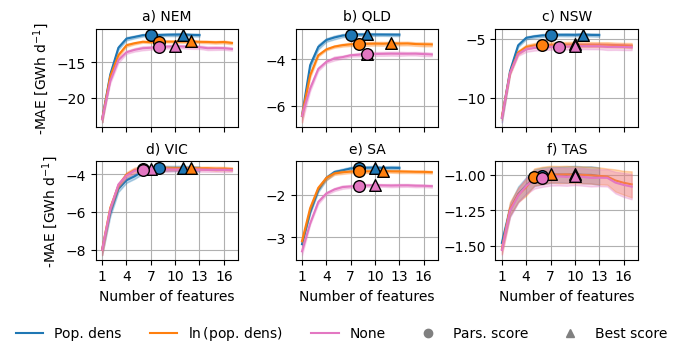

In [18]:
fig, ax = plt.subplots(2, 3, figsize=(7,3))

for i, r in enumerate(regions):
    p1 = plot_feature_selection(
        ax.flatten()[i],
        features_dict_best[r],
        "Pop. dens.",
        features_dict_pars[r],
        col1="tab:blue", 
        col2="tab:blue"
    )
    p2 = plot_feature_selection(
        ax.flatten()[i],
        features_log_mask_dict_best[r],
        r"$\ln$(pop. dens)",
        features_log_mask_dict_pars[r],
        col1="tab:orange", 
        col2="tab:orange"
    )
    p3 = plot_feature_selection(
        ax.flatten()[i],
        features_no_mask_dict_best[r],
        "None",
        features_no_mask_dict_pars[r],
        col1="tab:pink",
        col2="tab:pink"
    )
    # ax.flatten()[i].text(0.05, 0.9, r, transform=ax.flatten()[i].transAxes)
    ax.flatten()[i].set_title(letters[i] + ") " + r, fontsize=10)
    
    if i in [0, 1, 2]:
        ax.flatten()[i].set_xticklabels([])
        ax.flatten()[i].set_xlabel("")
    if i in [1, 2, 4, 5]:
        ax.flatten()[i].set_ylabel("")
    
plt.subplots_adjust(hspace=0.35, wspace=0.4)
    
# handles, labels = ax.flatten()[i].get_legend_handles_labels()
# fig.legend(handles, labels, loc=(0.1, 0.5), ncol=3, frameon=False)

# Manual legend   
col1 = Line2D([0], [0], marker='', color="tab:blue", linestyle="-")
col2 = Line2D([0], [0], marker='', color="tab:orange", linestyle="-")
col3 = Line2D([0], [0], marker='', color="tab:pink", linestyle="-")
circle = Line2D([0], [0], marker='o', markeredgecolor="gray", markerfacecolor="gray", linestyle="")
triangle = Line2D([0], [0], marker='^', markeredgecolor="gray", markerfacecolor="gray", linestyle="")
ax[1,0].legend(
    [col1, col2, col3, circle, triangle],
    ["Pop. dens", r"$\ln$(pop. dens)", "None", "Pars. score", "Best score"],
    loc=(-0.6, -0.9),
    ncol=5,
    frameon=False
)
plt.savefig("figures/nFeatures_compare_masks.pdf", format="pdf", bbox_inches="tight")

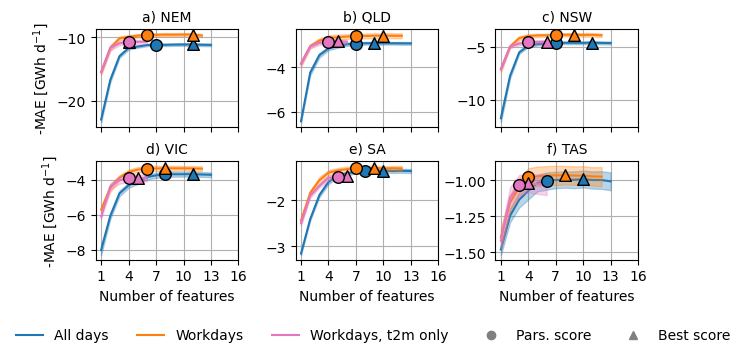

In [19]:
fig, ax = plt.subplots(2, 3, figsize=(7,3))

for i, r in enumerate(regions):
    p1 = plot_feature_selection(
        ax.flatten()[i],
        features_dict_best[r],
        "All days",
        features_dict_pars[r],
        col1="tab:blue",
        col2="tab:blue"
    )
    p2 = plot_feature_selection(
        ax.flatten()[i],
        features_no_wknd_no_xmas_dict_best[r],
        "Workdays",
        features_no_wknd_no_xmas_dict_pars[r],
        col1="tab:orange",
        col2="tab:orange"
    )
    p3 = plot_feature_selection(
        ax.flatten()[i],
        features_t2m_only_best[r],
        "Workdays, t2m only",
        features_t2m_only_pars[r],
        col1="tab:pink",
        col2="tab:pink"
    )
    
    ax.flatten()[i].set_xticks(range(17)[::3])
    ax.flatten()[i].set_xticklabels(range(1, 18)[::3])
    
    ax.flatten()[i].set_title(letters[i] + ") " + r, fontsize=10)
    
    if i in [0, 1, 2]:
        ax.flatten()[i].set_xticklabels([])
        ax.flatten()[i].set_xlabel("")
    if i in [1, 2, 4, 5]:
        ax.flatten()[i].set_ylabel("")
    
plt.subplots_adjust(hspace=0.35, wspace=0.4)
    
# handles, labels = ax.flatten()[i].get_legend_handles_labels()
# fig.legend(handles, labels, loc=(0.1, 0.5), ncol=3, frameon=False)

# Manual legend   
col1 = Line2D([0], [0], marker='', color="tab:blue", linestyle="-")
col2 = Line2D([0], [0], marker='', color="tab:orange", linestyle="-")
col3 = Line2D([0], [0], marker='', color="tab:pink", linestyle="-")
circle = Line2D([0], [0], marker='o', markeredgecolor="gray", markerfacecolor="gray", linestyle="")
triangle = Line2D([0], [0], marker='^', markeredgecolor="gray", markerfacecolor="gray", linestyle="")
ax[1,0].legend(
    [col1, col2, col3, circle, triangle],
    ["All days", "Workdays", "Workdays, t2m only", "Pars. score", "Best score"],
    loc=(-0.6, -0.9),
    ncol=5,
    frameon=False
)
plt.savefig("figures/nFeatures_compare_workdays.pdf", format="pdf", bbox_inches="tight")

# Hyperparameters

In [18]:
# Population density mask, all data
hyperparameters_dict = fn.read_results(
    "hyperparameters", MARKET, regions, "pop_dens_mask",
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    False, False, REMOVE_MONTH, "best", RESULTS_PATH
)

In [19]:
# Population density mask, remove weekends and Xmas
hyperparameters_no_wknd_no_xmas_dict = fn.read_results(
    "hyperparameters", MARKET, regions, "pop_dens_mask",
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    False, False, REMOVE_MONTH, "parsimonious", RESULTS_PATH
)

In [20]:
hyperparameters_dict

{'NEM':                     0
 max_depth          21
 max_leaf_nodes    177
 min_samples_leaf    5
 n_estimators      415,
 'QLD':                     0
 max_depth          13
 max_leaf_nodes    174
 min_samples_leaf    7
 n_estimators      448,
 'NSW':                     0
 max_depth          28
 max_leaf_nodes    175
 min_samples_leaf    6
 n_estimators      319,
 'VIC':                     0
 max_depth          21
 max_leaf_nodes    177
 min_samples_leaf    5
 n_estimators      415,
 'SA':                     0
 max_depth          28
 max_leaf_nodes    175
 min_samples_leaf    6
 n_estimators      319,
 'TAS':                     0
 max_depth          40
 max_leaf_nodes    143
 min_samples_leaf    8
 n_estimators      282}

In [21]:
hyperparameters_no_wknd_no_xmas_dict

{'NEM':                     0
 max_depth          21
 max_leaf_nodes    177
 min_samples_leaf    5
 n_estimators      415,
 'QLD':                     0
 max_depth          15
 max_leaf_nodes    191
 min_samples_leaf    8
 n_estimators      428,
 'NSW':                     0
 max_depth          37
 max_leaf_nodes    142
 min_samples_leaf    6
 n_estimators      299,
 'VIC':                     0
 max_depth          21
 max_leaf_nodes    177
 min_samples_leaf    5
 n_estimators      415,
 'SA':                     0
 max_depth          21
 max_leaf_nodes    177
 min_samples_leaf    5
 n_estimators      415,
 'TAS':                     0
 max_depth          37
 max_leaf_nodes    142
 min_samples_leaf    6
 n_estimators      299}

# Predictions

In [22]:
def NEM_reorder(d):
    """
    Quick hack to reorder dictionary keys
    """
    return {k: d[k] for k in ["NEM", "cNEM", "QLD", "NSW", "VIC", "SA", "TAS"]}

In [23]:
def concat_states(df_dict, exclude=["NEM"], new_key = "cNEM"):
    """
    Sum observations and predictions for all states (i.e. not NEM)
    """
    def print_nan(df):
        print(df[df.isnull().any(axis=1)].shape)
        
    import copy
    
    dfs = copy.deepcopy(df_dict)
    
    n_keys = len(df_dict.keys())
    
    for e in exclude:
        dfs.pop(e)
    
    regions = list(dfs.keys())
    
    df_dict[new_key] = dfs[regions[0]]
    for r in regions[1:]:
        df_dict[new_key] += dfs[r]
    df_dict[new_key] = df_dict[new_key].dropna()
    
    # print_nan(dfs["QLD"])
    # print_nan(df_dict["QLD"])
    
    return df_dict

In [24]:
def get_scores(res_dict, metrics, metric_names):
    """
    Compute the scores for each region in res_dict.
    """
    n = len(metrics)
    df = pd.DataFrame(index=res_dict.keys(), columns=metric_names)
    for r in res_dict.keys():
        rm_nan = res_dict[r]#.dropna()
        scores = fn.compute_scores(rm_nan["observation"], rm_nan["prediction"], metrics)
        df.loc[r] = [scores[i] for i in range(-1, n)]
    return df.astype("float")

In [25]:
# Population density mask, all data
training_dict_best = fn.read_results(
    "training", MARKET, regions, "pop_dens_mask",
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    False, False, REMOVE_MONTH, "best", RESULTS_PATH
)
training_dict_best = concat_states(training_dict_best)
training_dict_best = NEM_reorder(training_dict_best)

training_dict_pars = fn.read_results(
    "training", MARKET, regions, "pop_dens_mask",
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    False, False, REMOVE_MONTH, "parsimonious", RESULTS_PATH
)
training_dict_pars = concat_states(training_dict_pars)
training_dict_pars = NEM_reorder(training_dict_pars)

In [26]:
test_dict_best = fn.read_results(
    "test", MARKET, regions, "pop_dens_mask",
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    False, False, REMOVE_MONTH, "best", RESULTS_PATH
)
test_dict_best = concat_states(test_dict_best)
test_dict_best = NEM_reorder(test_dict_best)

test_dict_pars = fn.read_results(
    "test", MARKET, regions, "pop_dens_mask",
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    False, False, REMOVE_MONTH, "parsimonious", RESULTS_PATH
)
test_dict_pars = concat_states(test_dict_pars)
test_dict_pars = NEM_reorder(test_dict_pars)

In [27]:
# Population density mask, remove weekends and Xmas
training_no_wknd_no_xmas_dict_pars = fn.read_results(
    "training", MARKET, regions, "pop_dens_mask",
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    True, True, REMOVE_MONTH, "best", RESULTS_PATH
)
training_no_wknd_no_xmas_dict_pars = concat_states(training_no_wknd_no_xmas_dict_pars)
training_no_wknd_no_xmas_dict_pars = NEM_reorder(training_no_wknd_no_xmas_dict_pars)

test_no_wknd_no_xmas_dict_pars = fn.read_results(
    "test", MARKET, regions, "pop_dens_mask",
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    True, True, REMOVE_MONTH, "parsimonious", RESULTS_PATH
)
test_no_wknd_no_xmas_dict_pars = concat_states(test_no_wknd_no_xmas_dict_pars)
test_no_wknd_no_xmas_dict_pars = NEM_reorder(test_no_wknd_no_xmas_dict_pars)

In [28]:
metric_names = [
    "r",
    "R2",
    # "MAE",
    "MSE",
    "MAPE",
    # "MedAE"
]

In [29]:
full_metric_names = [
    "Pearson correlation",
    "Explained variance",
    "Mean squared error",
    "Median absolute percentage error"
]

In [30]:
metric_labels = [
    r"$r$ [-]",
    r"$R^{2}$ [-]",
    # "MAE",
    r"MSE [(GWh / day)$^{2}$]",
    "MAPE [%]",
    # "MedAE"
]

In [31]:
# scikit learn metrics (correlation will be computed too, within fn.compute_scores)
sklearn_metrics = [
    r2_score,
    # mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    # median_absolute_error
]

In [32]:
training_scores_best = get_scores(training_dict_best, sklearn_metrics, metric_names)

In [33]:
training_scores_best

,r,R2,MSE,MAPE
NEM,0.949844,0.900852,1.303289e+08,0.016795
cNEM,0.950865,0.902256,1.284759e+08,0.016359
QLD,0.944240,0.890550,9.664967e+06,0.016018
NSW,0.955906,0.912504,2.368373e+07,0.018916
VIC,0.954983,0.910350,1.428816e+07,0.023237
SA,0.958954,0.916943,1.997360e+06,0.032744
TAS,0.904448,0.815507,1.085093e+06,0.030910


In [34]:
training_scores_pars = get_scores(training_dict_pars, sklearn_metrics, metric_names)

In [35]:
training_no_wknd_no_xmas_scores_pars = get_scores(training_no_wknd_no_xmas_dict_pars, sklearn_metrics, metric_names)

In [36]:
test_scores_best = get_scores(test_dict_best, sklearn_metrics, metric_names)

In [37]:
test_scores_pars = get_scores(test_dict_pars, sklearn_metrics, metric_names)

In [38]:
test_no_wknd_no_xmas_scores_pars = get_scores(test_no_wknd_no_xmas_dict_pars, sklearn_metrics, metric_names)

In [39]:
def scatter(ax, metric, train_scores, test_scores, label, RMSE=False):
    """
    Scatter train and test scores for multiple models
    """     
    colors = ["tab:blue", "tab:orange", "tab:pink"]
    x_offsets = [-0.2, 0, 0.2]
    
    for _train, _test, offset, color in zip(train_scores, test_scores, x_offsets, colors):
        if metric in ["MAE", "MSE", "MedAE"]: # MWh to GWh
            _train = _train / 1000
            _test = _test / 1000
        if metric == "MAPE": # fraction to %
            _train = _train * 100
            _test = _test * 100
        if (metric == "MSE") & RMSE: # MSE to RMSE
            _train = np.sqrt(_train)
            _test = np.sqrt(_test)
            label = "RMSE [GWh / day]"
        
        x = len(_train)
        
        for i, (tr, ts) in enumerate(zip(_train[metric], _test[metric])):
            ax.plot((i + offset, i + offset), (tr, ts), color=color)
        
        ax.scatter(np.arange(x) + offset, _train[metric], marker='o', lw=0.5, ec="lightgray", color=color, label="Train")
        ax.scatter(np.arange(x) + offset, _test[metric], marker='D', lw=0.5, ec="lightgray", color=color, label="Test")
        
    ax.set_ylabel(label)
    ax.set_xticks(range(x))
    ax.set_xticklabels(_train.index, rotation=30)
    
    for x in np.arange(0.5, 6.5, 1):
        ax.axvline(x, color="lightgray", ls="-")
    
    return ax

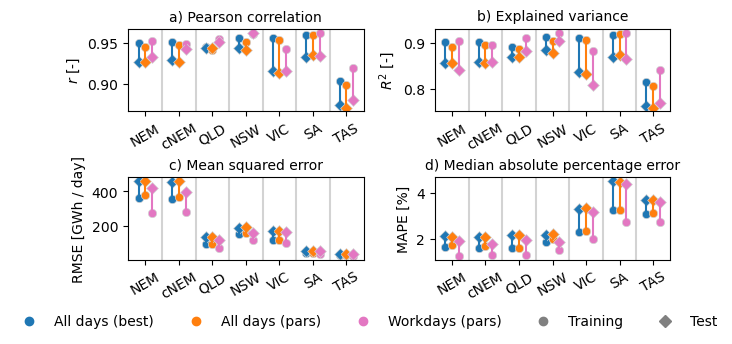

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(7,3))

for i, m in enumerate(metric_names):
    p = scatter(ax.flatten()[i], m,
            [training_scores_best, training_scores_pars, training_no_wknd_no_xmas_scores_pars],
            [test_scores_best, test_scores_pars, test_no_wknd_no_xmas_scores_pars],
               metric_labels[i],
               RMSE=True)
    ax.flatten()[i].set_title(letters[i] + ") " + full_metric_names[i], fontsize=10)
    

# Manual legend   
col1 = Line2D([0], [0], marker='o', markeredgecolor="tab:blue", markerfacecolor="tab:blue", linestyle="")
col2 = Line2D([0], [0], marker='o', markeredgecolor="tab:orange", markerfacecolor="tab:orange", linestyle="")
col3 = Line2D([0], [0], marker='o', markeredgecolor="tab:pink", markerfacecolor="tab:pink", linestyle="")
circle = Line2D([0], [0], marker='o', markeredgecolor="gray", markerfacecolor="gray", linestyle="")
triangle = Line2D([0], [0], marker='D', markeredgecolor="gray", markerfacecolor="gray", linestyle="")
ax[1,0].legend(
    [col1, col2, col3, circle, triangle],
    ["All days (best)", "All days (pars)", "Workdays (pars)", "Training", "Test"],
    loc=(-0.5, -0.9),
    ncol=5,
    frameon=False
)
    
plt.subplots_adjust(hspace=0.8, wspace=0.3)

plt.savefig("figures/skill_training2010-2016_test2017-2019.pdf", format="pdf", bbox_inches="tight")

### Time series

In [41]:
def plot_ts(ax, region, tra_dict, tes_dict, start=None, end=None, colors=["tab:blue", "tab:orange"], dayofyear=False):
    """
    Plot observation and prediction time series for a region, for a specified period.
    """
    y = pd.concat([tra_dict[region], tes_dict[region]])
    y.index = pd.to_datetime(y.index)
    y = y / 1000 # MWh to GWh
    
    
    
    y.loc[slice(start, end)]["observation"].plot(
        ax=ax, color=colors[0],
        # xticks=pd.date_range(start + "-01-01", start + "-12-31", freq="1MS")
    )
    y.loc[slice(start, end)]["prediction"].plot(
        ax=ax, color=colors[1],
        # xticks=pd.date_range(start + "-01-01", start + "-12-31", freq="1MS")
    )
    
    if int(start) < 2017:
        ax.axvline(pd.Timestamp("2017"), color="k")
    ax.set_ylabel(r"Demand [GWh d$^{-1}$]")
    # ax.legend(loc="lower left")
    # ax.text(0.01, 0.9, region, transform=ax.transAxes)
    return ax

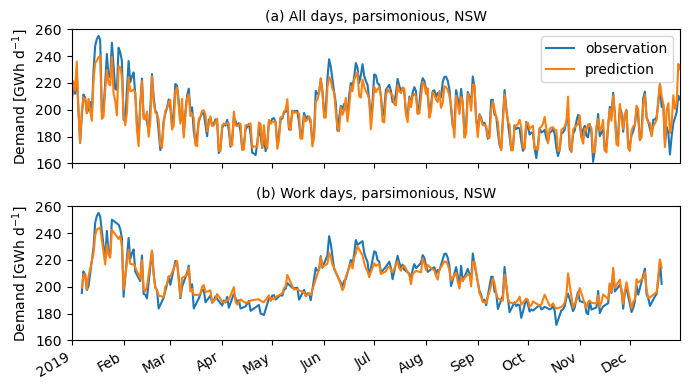

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(7,4))

plot_ts(ax[0], "NSW", training_dict_pars, test_dict_pars, "2019", "2020")
p = ax[0].set_title("(a) All days, parsimonious, NSW", fontsize=10)
ax[0].legend()

plot_ts(ax[1], "NSW", training_no_wknd_no_xmas_dict_pars, test_no_wknd_no_xmas_dict_pars, "2019", "2020")
ax[1].set_title("(b) Work days, parsimonious, NSW", fontsize=10)

for a in ax:
    a.set_ylim(160, 260)
    a.set_yticks(range(160, 261, 20))
    a.set_xlim(pd.to_datetime("2019-01-01"), pd.to_datetime("2019-12-31"))
    a.set_xticks(pd.date_range("2019-01-01", "2019-12-31", freq="1MS"))
    a.xaxis.set_major_formatter(matplotlib.dates.ConciseDateFormatter(a.xaxis.get_major_locator()))#.DateFormatter('%Y-%m-%d'))

ax[0].tick_params(axis='x', which='minor', bottom=False) 
ax[0].set_xticklabels([])

plt.tight_layout()

plt.savefig("figures/time_series_demand_NSW_2019.pdf", format="pdf", bbox_inches="tight")

### Obs vs. predictions

In [43]:
def get_error(df):
    """
    Error of predictions
    """
    return df["observation"] - df["prediction"]

In [44]:
def plot_scatter(ax, df, color, c=None, cmap=None):
    """
    Plot pred vs obs
    """
    df = df.copy() / 1000
    
    ax.scatter(df["observation"], df["prediction"], c=c, cmap=cmap, color=color, alpha=0.5)
    ax.plot(
        [df.min(), df.max()], [df.min(), df.max()],
        c="k", ls="-"
    )

In [45]:
# Prepare predictors
files = fn.get_predictor_files(MARKET, "pop_dens_mask")

In [46]:
pred_ds = xr.open_mfdataset(files, combine="nested", compat="override")

In [47]:
t2m = pred_ds["t2m"].sel(
    time=slice(str(FIRST_TRAIN_YEAR), str(LAST_TEST_YEAR))
).compute()

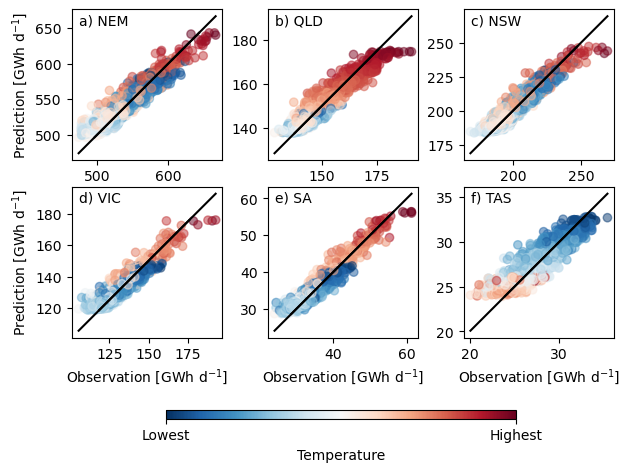

In [48]:
fig, ax = plt.subplots(2, 3, figsize=(7,4.5))

for i, r in enumerate(regions):
    cal = fn.get_calendar(MARKET, r)
    plot_scatter(
        ax.flatten()[i],
        pd.concat([training_no_wknd_no_xmas_dict_pars[r], test_no_wknd_no_xmas_dict_pars[r]], axis=0),
        color=None,
        c=fn.remove_time(t2m.sel(region=r), True, True, 0, cal),
        cmap="RdBu_r"
    )
    ax.flatten()[i].text(0.05, 0.9, letters[i] + ") " + r, transform=ax.flatten()[i].transAxes)
    ax.flatten()[i].set_aspect('equal', adjustable='box')
    
for i in [0, 3]:
    ax.flatten()[i].set_ylabel(r"Prediction [GWh d$^{-1}$]")
for i in [3, 4, 5]:
    ax.flatten()[i].set_xlabel(r"Observation [GWh d$^{-1}$]")
    
# Colormap
cmap = plt.get_cmap('RdBu_r')
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=100)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap.set_array([])

cax = fig.add_axes([0.26, -0.05, 0.5, 0.02])
cbar = fig.colorbar(scalarMap, cax=cax, ticks=[0, 100], orientation="horizontal")
cbar.ax.set_xticklabels(["Lowest", "Highest"])
cbar.ax.set_xlabel("Temperature")
    
plt.subplots_adjust(hspace=0.05, wspace=0.3)

plt.savefig("figures/prediction_vs_obs.pdf", format="pdf", bbox_inches="tight")

# Permutation importances

Compute these on the training and test sets. Differences tell us what the model actually used to make the predictions.

In [49]:
dem_da = xr.open_dataset("/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_2010-2020_stl.nc")["demand_stl"]

In [50]:
# Prepare predictors
files = fn.get_predictor_files("NEM", "pop_dens_mask")
pred_ds = xr.open_mfdataset(files, combine="nested", compat="override")

In [51]:
# Prepare dataframe for machine learning
region_dfs = {}
for r in regions:
    cal = fn.get_calendar(MARKET, r)
    demand = fn.remove_time(dem_da, True, True, 0, cal)
    pred = fn.remove_time(pred_ds, True, True, 0, cal)
    df = fn.to_dataframe(demand, pred, r)
    selected_preds = fn.parse_features(fn.sel_model(features_no_wknd_no_xmas_dict_pars[r])["feature_names"])[:]
    print(selected_preds[::-1])
    df = df[["demand"] + selected_preds[::-1]]
    region_dfs[r] = df

['t2max', 'msdwswrf', 't2m', 'w10', 'cdd', 't2m3']
['t2max', 'msdwswrf', 't2m', 'q', 'w10', 'cdd', 't2m4']
['t2max', 'msdwswrf', 't2m', 'mtpr', 'w10', 't2m4', 't2m3']
['t2max', 'msdwswrf', 't2m', 'w10', 't2m4', 't2m3']
['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2m4', 't2m3']
['t2m', 'w10', 'rh', 't2m3']


In [52]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [53]:
perm_train = {}
perm_test = {}

for r in regions:
    cal = fn.get_calendar(MARKET, r)
    dem = fn.remove_time(dem_da, True, True, 0, cal)
    test_len = dem.sel(time=slice(str(FIRST_TEST_YEAR), str(LAST_TEST_YEAR))).time.values.shape[0]
    
    train_X, test_X, train_y, test_y = fn.split(
        fn.sel_train_test(region_dfs[r], FIRST_TRAIN_YEAR, LAST_TEST_YEAR),
        "demand",
        test_size=test_len,
        random_state=0,
        shuffle=False
    )
    
    # Finalise model
    rf = ExtraTreesRegressor(
        n_estimators=int(hyperparameters_no_wknd_no_xmas_dict[r].loc["n_estimators"].values),
        min_samples_leaf=int(hyperparameters_no_wknd_no_xmas_dict[r].loc["min_samples_leaf"].values),
        max_depth=int(hyperparameters_no_wknd_no_xmas_dict[r].loc["max_depth"].values),
        max_leaf_nodes=int(hyperparameters_no_wknd_no_xmas_dict[r].loc["max_leaf_nodes"].values),
        random_state=0,
    )
    
    model_train, _ = fn.predict_forest(train_y, train_X, train_X, rf)
    model_test, _ = fn.predict_forest(train_y, train_X, test_X, rf)
    
    perm_train[r] = fn.perm_imp(
        model_train,
        train_X,
        train_y,
        n_repeats=200,
    )
    perm_test[r] = fn.perm_imp(
        model_test,
        test_X,
        test_y,
        n_repeats=200,
    )

In [54]:
def scatter_perm(ax, imp_dict, x_nudge, color, label=None, plot_cloud=True):
    """
    Scatter importances with mean and std overlaid
    """
    n = imp_dict.importances.shape[-1]
    nx = len(imp_dict.importances_mean)

    if plot_cloud:
        ax.scatter(
            [np.repeat(i+x_nudge, n) + np.random.normal(0, 0.05, size=n) for i in range(nx)],
            imp_dict.importances,
            alpha=0.5,
            color=color
        )
    
    # ax.scatter(np.arange(nx)+x_nudge, imp_dict.importances_mean, color="k")
    ax.errorbar(
        np.arange(nx)+x_nudge,
        imp_dict.importances_mean,
        yerr=imp_dict.importances_std,
        color=color,
        markeredgecolor="k",
        fmt="o",
        markersize=5,
        label=label
    )

In [55]:
def plot_perm(ax, pTrain, pTest, features, x_nudge=0.2, colors=["tab:blue", "tab:orange"], plot_cloud=True):
    """
    Scatter permutation importantes for train and test
    """
    nx = len(pTrain.importances_mean)
    
    scatter_perm(ax, pTrain, -x_nudge, colors[0], plot_cloud=plot_cloud, label="Train")
    scatter_perm(ax, pTest, x_nudge, colors[1], plot_cloud=plot_cloud, label="Test")

    ax.set_xticks(range(nx))
    ax.set_xticklabels(fn.parse_features(fn.sel_model(features)["feature_names"])[::-1], rotation=-30)
    
    ax.set_ylabel(r"$R^{2}$ decrease [-]")
    
    for x in range(nx-1):
        ax.axvline(x + 0.5, color="lightgray", ls="-")
        
    # ax.grid(axis="y")

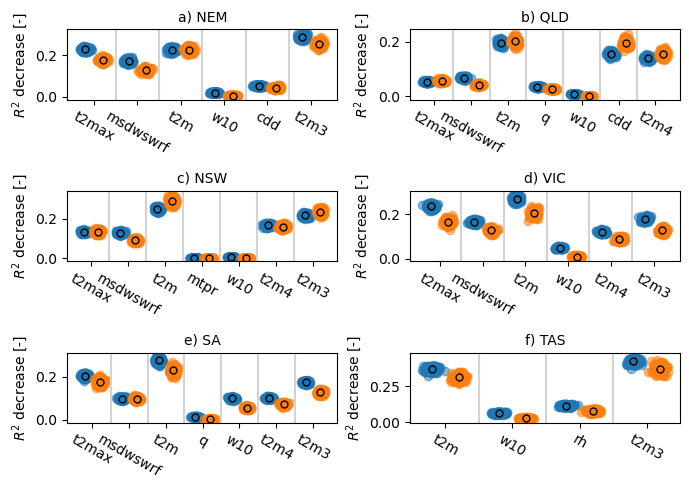

In [56]:
fig, ax = plt.subplots(3, 2, figsize=(7,5))

for i, r in enumerate(regions):
    plot_perm(ax.flatten()[i], perm_train[r], perm_test[r], features_no_wknd_no_xmas_dict_pars[r])
    # ax.flatten()[i].text(0.9, 0.9, r, transform=ax.flatten()[i].transAxes)
    ax.flatten()[i].set_title(letters[i] + ") " + r, fontsize=10)
plt.tight_layout()

# SHAP analysis

In [57]:
trainX_dict = {}
testX_dict = {}

shap_train = {}
shap_test = {}

for r in regions:
    cal = fn.get_calendar(MARKET, r)
    dem = fn.remove_time(dem_da, True, True, 0, cal)
    test_len = dem.sel(time=slice(str(FIRST_TEST_YEAR), str(LAST_TEST_YEAR))).time.values.shape[0]
    
    train_X, test_X, train_y, test_y = fn.split(
        fn.sel_train_test(region_dfs[r], FIRST_TRAIN_YEAR, LAST_TEST_YEAR),
        "demand",
        test_size=test_len,
        random_state=0,
        shuffle=False
    )
    
    trainX_dict[r] = train_X
    testX_dict[r] = test_X
        
    # Finalise model
    rf = ExtraTreesRegressor(
        n_estimators=int(hyperparameters_no_wknd_no_xmas_dict[r].loc["n_estimators"].values),
        min_samples_leaf=int(hyperparameters_no_wknd_no_xmas_dict[r].loc["min_samples_leaf"].values),
        max_depth=int(hyperparameters_no_wknd_no_xmas_dict[r].loc["max_depth"].values),
        max_leaf_nodes=int(hyperparameters_no_wknd_no_xmas_dict[r].loc["max_leaf_nodes"].values),
        random_state=0,
    )
    
    model_train, _ = fn.predict_forest(train_y, train_X, train_X, rf)
    model_test, _ = fn.predict_forest(train_y, train_X, test_X, rf)
    
    explainer = shap.Explainer(rf)
    shap_train[r] = explainer.shap_values(train_X)
    shap_test[r] = explainer.shap_values(test_X)

In [58]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [59]:
def plot_shap(vals, features, feature_names, colorbar=True, fontsize=10):
    """
    Custom shap summary plot
    """
    pl = shap.summary_plot(
        vals,
        features,
        feature_names=feature_names,
        plot_type="dot",
        cmap="viridis",
        color_bar=colorbar,
        show=False,
        plot_size=None
    )

    ax = plt.gca()
    for pos in ["top", "bottom", "left", "right"]:
        ax.spines[pos].set_visible(True)

    # xmin = roundup(np.min(vals), 1)
    # xmax = roundup(np.max(vals), 1)
    # if xmax - xmin > 800:
        # gap = 4000
    # elif xmax - xmin > 5000:
        # gap = 1000
    # else:
        # gap = 500
#     
    # ax.set_xticks(np.arange(xmin, xmax, gap))
    ax.axes.grid(visible=True)
    ax.axvline(0, c="k")
    ax.set_xlabel("SHAP value [GWh / day]", fontsize=fontsize)
    
    ax.yaxis.label.set_size(fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize, pad=0)
    
    # ax.set_yticklabels(range(vals.shape[1]), labelpad=0)
    
    # fig.colorbar(pl, ax=ax)
    
    return ax

Text(0.5, 0, 'Feature value')

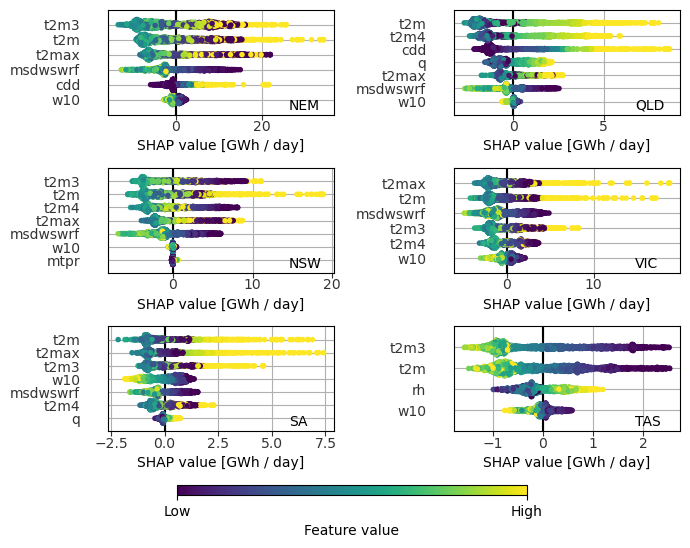

In [60]:
fig = plt.figure(figsize=(7,5))

for i, r in enumerate(regions):
    
    fig.add_subplot(3, 2, i+1)
    a = plot_shap(
        shap_train[r] / 1000,
        trainX_dict[r],
        fn.parse_features(fn.sel_model(features_no_wknd_no_xmas_dict_pars[r])["feature_names"])[::-1],
        colorbar=False
    )
    a.text(0.8, 0.05, r, transform=a.transAxes)
    
# Figure legend
cmap = plt.get_cmap('viridis')
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=100)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap.set_array([])

cax = fig.add_axes([0.26, 0.0, 0.5, 0.02])
cbar = fig.colorbar(scalarMap, cax=cax, ticks=[0, 100], orientation="horizontal")
cbar.ax.set_xticklabels(["Low", "High"])
cbar.ax.set_xlabel("Feature value")

### Combine SHAP with permutation importance

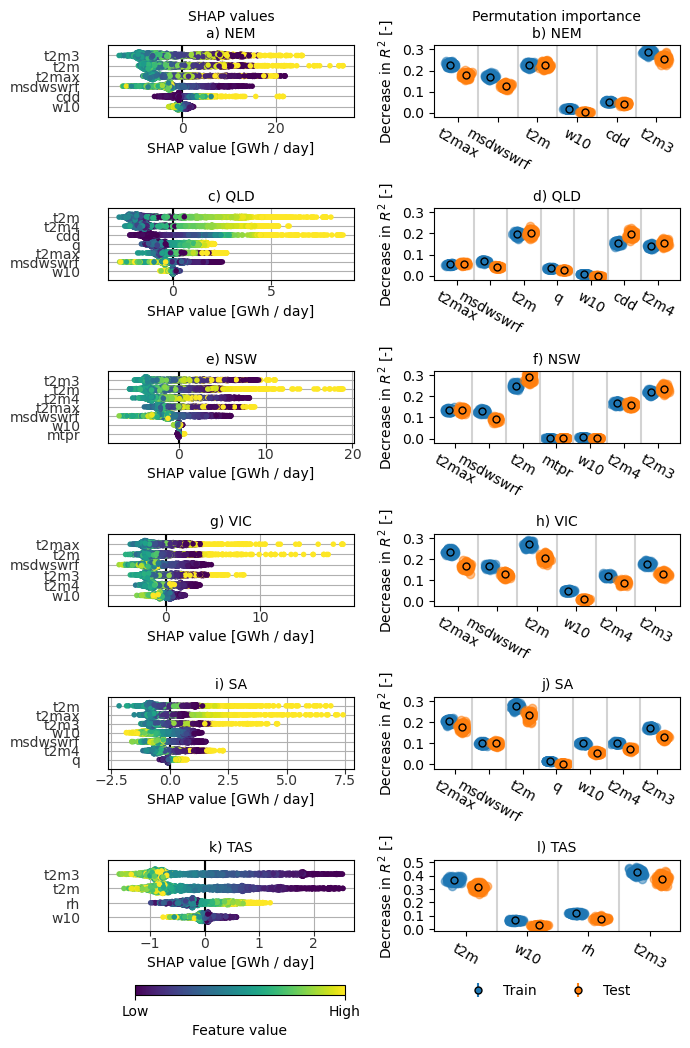

In [61]:
fig = plt.figure(figsize=(7,10))

for i, r in enumerate(regions):
    
    # SHAP
    fig.add_subplot(6, 2, i*2+1)
    
    ax = plot_shap(
        shap_train[r] / 1000,
        trainX_dict[r],
        fn.parse_features(fn.sel_model(features_no_wknd_no_xmas_dict_pars[r])["feature_names"])[::-1],
        colorbar=False
    )
    # ax.text(0.8, 0.05, r, transform=a.transAxes)
    
    # PIM
    ax2 = fig.add_subplot(6, 2, i*2+2)

    pim = plot_perm(ax2, perm_train[r], perm_test[r], features_no_wknd_no_xmas_dict_pars[r], plot_cloud=True)
    
    # Round up max value to nearest 0.1
    dmax = np.max([np.max(perm_train[r]["importances_mean"]), np.max(perm_test[r]["importances_mean"])])
    dmax = fn.roundup(dmax, 0.1)
    
    ax2.set_ylim(-0.02, dmax+0.02)
    ax2.set_yticks(np.arange(0, dmax+0.01, 0.1))
    ax2.set_ylabel(r"Decrease in $R^{2}$ [-]")
    
    if i == 5:
        ax2.legend(loc=(0.1, -1), ncols=2, frameon=False)
        
    if i == 0:
        ax.set_title("SHAP values\n" + letters[i*2] + ") " + r, fontsize=10)
        ax2.set_title("Permutation importance\n" + letters[i*2 + 1] + ") " + r, fontsize=10)
    else:
        ax.set_title(letters[i*2] + ") " + r, fontsize=10)
        ax2.set_title(letters[i*2 + 1] + ") " + r, fontsize=10)
    
# Figure legend
cmap = plt.get_cmap('viridis')
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=100)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap.set_array([])

cax = fig.add_axes([0.2, 0.0, 0.3, 0.01])
cbar = fig.colorbar(scalarMap, cax=cax, ticks=[0, 100], orientation="horizontal")
cbar.ax.set_xticklabels(["Low", "High"])
cbar.ax.set_xlabel("Feature value")

plt.savefig("figures/shap_perm_imp_training2010-2016_test2017-2019.pdf", format="pdf", bbox_inches="tight")